In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Dense, MaxPooling1D, Flatten, LSTM,BatchNormalization
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from keras.optimizers import Adam

In [2]:
# Load Datasets
df = pd.read_csv('cleaned_reviews.csv')

In [3]:
df.head(10)

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0
5,positive,overall love this mouse the size weight clicki...,68,3.0
6,neutral,it stopped working,3,1.0
7,positive,my son uses school issued chromebook for schoo...,170,1.0
8,negative,loved this cute little mouse but it broke afte...,17,1.0
9,negative,should ve spent the money to get quality produ...,17,1.0


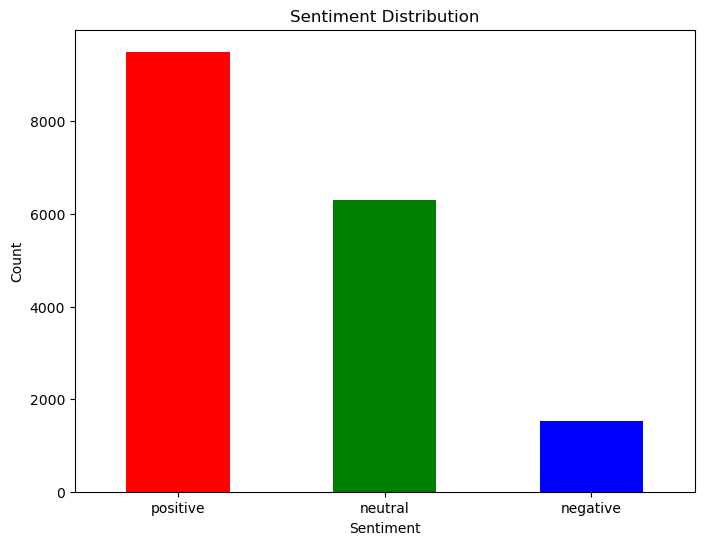

In [4]:
# Count the occurrences of each sentiment in the validation set
sentiment_counts = df['sentiments'].value_counts()

# Plot bar chart
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['red', 'green', 'blue'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17340 entries, 0 to 17339
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sentiments             17340 non-null  object 
 1   cleaned_review         17337 non-null  object 
 2   cleaned_review_length  17340 non-null  int64  
 3   review_score           17340 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 542.0+ KB


Pre-processing

In [6]:
def preprocessor(text):
    if isinstance(text, str):
        # Convert text to lowercase
        text = text.lower()
        # Remove not word characters or whitespace characters
        text = re.sub(r'[^\w\s]', '', text)
    return text

df['cleaned_review'] = df['cleaned_review'].apply(preprocessor)

#Handle missing values
df['cleaned_review'] = df['cleaned_review'].fillna("")

Splitting 80% Train 20% Validation and Label Encoder

In [7]:
#x_df = df['cleaned_review']
#y_df = df['sentiments']

# Tokenization
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_review'])
sequences = tokenizer.texts_to_sequences(df['cleaned_review'])

max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

#Select a single padded sequence
padded_sequence = padded_sequences[0]

# Convert labels to one-hot encoding and perform oversampling using SMOTE
le = LabelEncoder()
label_encoded = le.fit_transform(df['sentiments'])

smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(padded_sequences, label_encoded)

# Convert the oversampled labels to one-hot encoding
label_encoded_categorical = to_categorical(y_resampled)

# Splitting (70% train, 20% validation, 10% test)
x_train, x_temp, y_train, y_temp = train_test_split(x_resampled, label_encoded_categorical, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=1/3, random_state=42)

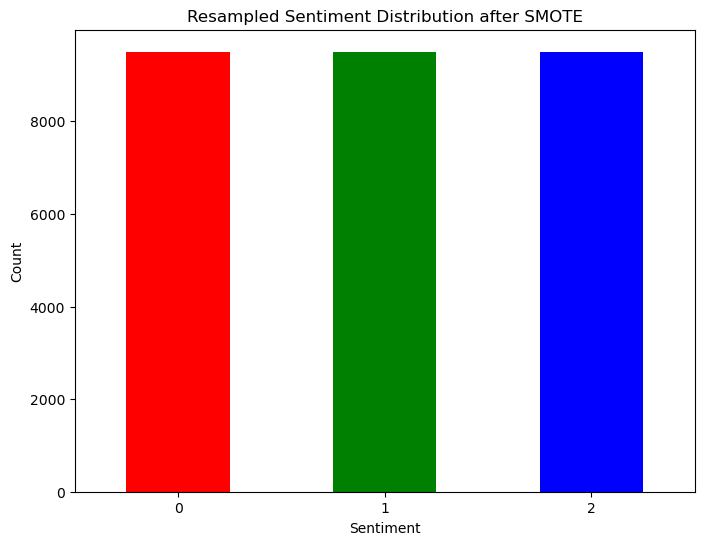

In [8]:
# Chart after SMOTE
resampled_sentiment_counts = pd.Series(y_resampled).value_counts().sort_index()

# Plot bar chart for resampled sentiments
plt.figure(figsize=(8, 6))
resampled_sentiment_counts.plot(kind='bar', color=['red', 'green', 'blue'])
plt.title('Resampled Sentiment Distribution after SMOTE')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [9]:
#Print each token in the sequence and the corresponding word
for token in padded_sequence:
    if token != 0:
        print(f"Token: {token}, Word: {reverse_word_index[token]}")

Token: 24, Word: i
Token: 284, Word: wish
Token: 44, Word: would
Token: 21, Word: have
Token: 696, Word: gotten
Token: 28, Word: one
Token: 2497, Word: earlier
Token: 34, Word: love
Token: 3, Word: it
Token: 4, Word: and
Token: 3, Word: it
Token: 293, Word: makes
Token: 49, Word: working
Token: 16, Word: in
Token: 9, Word: my
Token: 107, Word: laptop
Token: 22, Word: so
Token: 135, Word: much
Token: 768, Word: easier


Load Word Embedding Global Vectors (GloVe)

In [10]:
#Load GloVe Embeddings
glove_embeddings = {}
with open('glove.6B.100d.txt', encoding='utf-8') as glove_file:
  for line in glove_file:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings[word] = coefs

In [11]:
#Define vocabulary size for the embedding layer
vocabulary_size = len(tokenizer.word_index)+1

#Prepare the Embedding layer weights using GloVe embeddings
embedding_dim = 100
embedding_weights = np.zeros((vocabulary_size, embedding_dim))
for word, i in tokenizer.word_index.items():
  embedding_vector = glove_embeddings.get(word)
  if embedding_vector is not None:
    embedding_weights[i] = embedding_vector

Model Long Short Term Memmory

In [12]:
# Model with Embedding layer using pre-trained GloVe embeddings
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=100, weights=[embedding_weights], input_length=max_sequence_length, trainable=True))
model.add(LSTM(64, return_sequences=True, dropout=0.1))
model.add(BatchNormalization())
model.add(LSTM(32, return_sequences=False, dropout=0.1))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))

In [13]:
adam = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(x_train, 
                    y_train, 
                    validation_data=(x_val, y_val), 
                    batch_size=64, 
                    epochs=25)

Epoch 1/25


312/312 [==============================] - 267s 826ms/step - loss: 0.8751 - accuracy: 0.5963 - val_loss: 0.8109 - val_accuracy: 0.6338
Epoch 2/25
312/312 [==============================] - 242s 776ms/step - loss: 0.6460 - accuracy: 0.7145 - val_loss: 0.6217 - val_accuracy: 0.7322
Epoch 3/25
312/312 [==============================] - 269s 863ms/step - loss: 0.5643 - accuracy: 0.7553 - val_loss: 0.5465 - val_accuracy: 0.7710
Epoch 4/25
312/312 [==============================] - 279s 894ms/step - loss: 0.5083 - accuracy: 0.7864 - val_loss: 0.5698 - val_accuracy: 0.7611
Epoch 5/25
312/312 [==============================] - 280s 897ms/step - loss: 0.4539 - accuracy: 0.8111 - val_loss: 0.5609 - val_accuracy: 0.7601
Epoch 6/25
312/312 [==============================] - 260s 833ms/step - loss: 0.4129 - accuracy: 0.8314 - val_loss: 0.5619 - val_accuracy: 0.7792
Epoch 7/25
312/312 [==============================] - 189s 605ms/step - loss: 0.3751 - accuracy: 0.8456 - val_loss: 0.4785

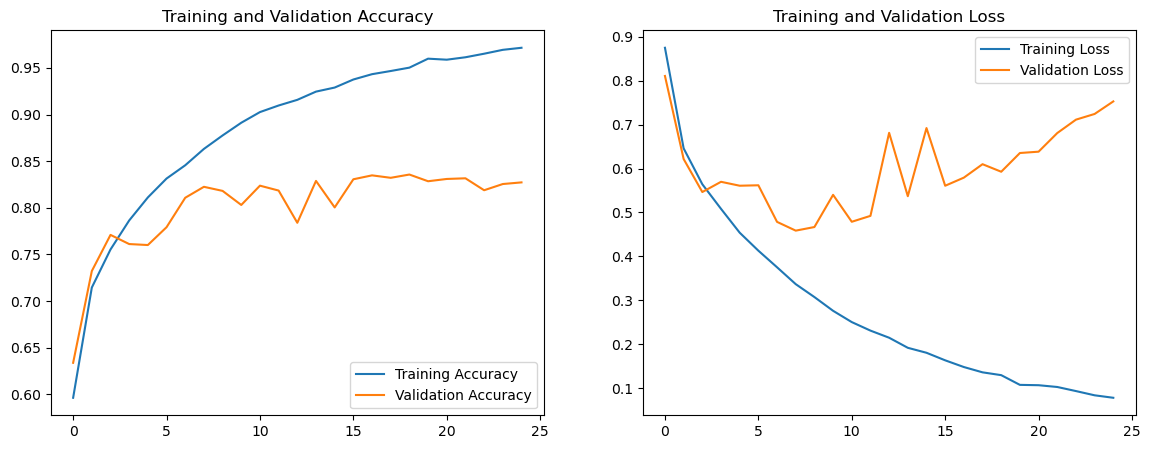

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Evaluate model

In [15]:
# Get Predictions
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)

# Convert probabilities to class labels
y_train_pred_class = np.argmax(y_train_pred, axis=1)
y_val_pred_class = np.argmax(y_val_pred, axis=1)

# Convert one-hot encoded targets bact to labels
y_train_classes = np.argmax(y_train, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Compute and print classification report for training data
print("Training Data:")
print(classification_report(y_train_classes, y_train_pred_class, target_names=le.classes_))

# Compute and print classification report for validation data
print("Validation data:")
print(classification_report(y_val_classes, y_val_pred_class, target_names=le.classes_))

179/179 [==============================] - 21s 117ms/step
Training Data:
              precision    recall  f1-score   support

    negative       0.99      0.99      0.99      6626
     neutral       0.99      0.99      0.99      6713
    positive       1.00      1.00      1.00      6617

    accuracy                           0.99     19956
   macro avg       0.99      0.99      0.99     19956
weighted avg       0.99      0.99      0.99     19956

Validation data:
              precision    recall  f1-score   support

    negative       0.80      0.82      0.81      1965
     neutral       0.75      0.73      0.74      1815
    positive       0.92      0.93      0.93      1922

    accuracy                           0.83      5702
   macro avg       0.83      0.83      0.83      5702
weighted avg       0.83      0.83      0.83      5702



179/179 [==============================] - 21s 118ms/step


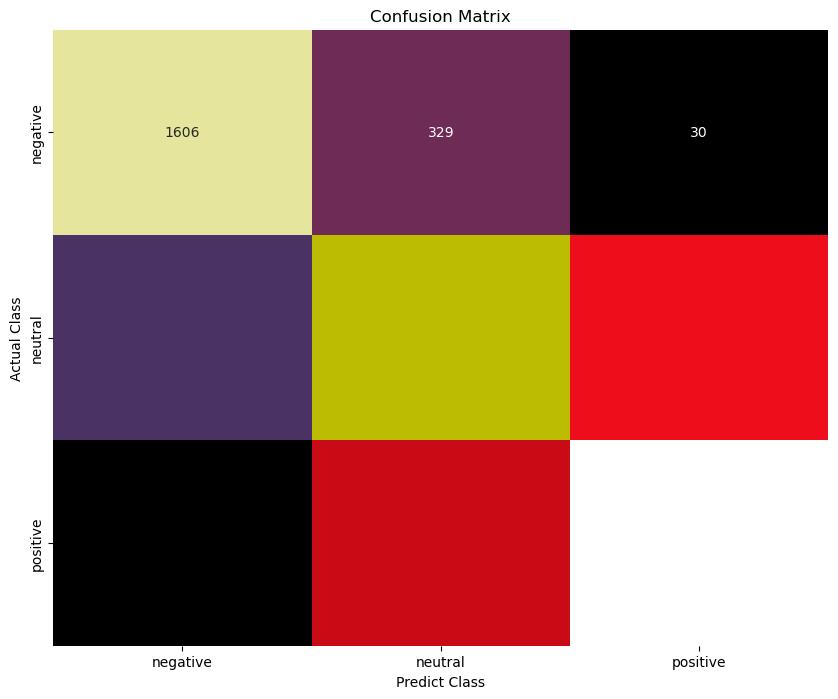

In [16]:
import sklearn
import seaborn as sns
# Predict classes on validation data
y_val_pred = model.predict(x_val)
y_val_pred_class = np.argmax(y_val_pred, axis=1)

# Convert one-hot encoded targets back to labels
y_val_classes = np.argmax(y_val, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val_classes, y_val_pred_class)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="gist_stern", cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.ylabel('Actual Class')
plt.xlabel("Predict Class")
plt.show()

In [17]:
# Create an empty list to store data
data = []

# Assuming you have 'x_val' as the list of text data, 'y_val_classes' as the true labels, and 'y_val_pred_class' as the predicted labels

# Convert class labels back to their original labels
actual_labels = le.inverse_transform(y_val_classes)
predicted_labels = le.inverse_transform(y_val_pred_class)

# Loop through the data and create rows
for text, actual, predicted in zip(y_val, actual_labels, predicted_labels):
    data.append([text, actual, predicted])

# Create a DataFrame from the list of data
results_df = pd.DataFrame(data, columns=['Text', 'Actual Label', 'Predicted Label'])

# Display the DataFrame
print(results_df)

                 Text Actual Label Predicted Label
0     [1.0, 0.0, 0.0]     negative        negative
1     [0.0, 1.0, 0.0]      neutral         neutral
2     [1.0, 0.0, 0.0]     negative         neutral
3     [0.0, 0.0, 1.0]     positive        positive
4     [0.0, 0.0, 1.0]     positive        positive
...               ...          ...             ...
5697  [0.0, 0.0, 1.0]     positive        positive
5698  [1.0, 0.0, 0.0]     negative        positive
5699  [0.0, 0.0, 1.0]     positive        positive
5700  [0.0, 1.0, 0.0]      neutral         neutral
5701  [1.0, 0.0, 0.0]     negative        negative

[5702 rows x 3 columns]


In [18]:
# Predict classes on the test set
y_test_pred = model.predict(x_test)

# Convert probabilities to class labels
y_test_pred_class = np.argmax(y_test_pred, axis=1)

# Convert one-hot encoded targets back to labels
y_test_classes = np.argmax(y_test, axis=1)

# Compute and print classification report for test data
print("Test Data:")
print(classification_report(y_test_classes, y_test_pred_class, target_names=le.classes_))

90/90 [==============================] - 11s 117ms/step
Test Data:
              precision    recall  f1-score   support

    negative       0.76      0.81      0.78       912
     neutral       0.76      0.73      0.74       975
    positive       0.92      0.91      0.91       964

    accuracy                           0.81      2851
   macro avg       0.81      0.81      0.81      2851
weighted avg       0.81      0.81      0.81      2851

